# James Hoffman Coffee Data Analysis

## The Goal
The main purpose of this analysis is to provide further visualizations of the coffee study performed by James Hoffman and his team. In addition, I hope to use modeling as a means to uplift any additional hidden insights.

Overall, this analysis does not provide much extra insight, but it provides interesting additional context as well as a good starting point for others to analyze as well.

If you have any questions or insights, feel free to reach out, or feel free to clone into this repository and try your own modeling techniques.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit
import statsmodels.graphics.mosaicplot as moplot
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import warnings

## Read in the data, and remove spaces for processing

In [2]:
df = pd.read_csv('GACTT_RESULTS_ANONYMIZED.csv')
df.head(20)

,Submission ID,Respondent ID,Submitted at,What is your age?,What is your ZIP code?,How many cups of coffee do you typically drink per day?,Where do you typically drink coffee?,Where do you typically drink coffee? (At home),Where do you typically drink coffee? (At the office),Where do you typically drink coffee? (On the go),...,Gender,Gender (please specify),Marital Status,Household Income,Education Level,Ethnicity/Race,Ethnicity/Race (please specify),Employment Status,Number of Children,Political Affiliation
0,gMR29l,vDzkBA,9/11/23 20:50,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BkPN0e,9Z4VME,9/11/23 20:52,25-34 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W5G8jj,XoNLQj,9/12/23 1:33,25-34 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4xWgGr,Gp7gde,9/12/23 12:58,35-44 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,QD27Q8,Bp9ogQ,9/12/23 15:24,25-34 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,V0LPeM,begNlo,9/13/23 5:10,55-64 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,V0Gaxg,kGxEbJ,9/14/23 17:42,18-24 years old,10023,NaN,"At a cafe, At the office, At home, On the go",True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,AdzRL0,WRdz1a,9/14/23 17:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,LbWda2,y4rLgx,9/18/23 19:02,25-34 years old,1930,Less than 1,At a cafe,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,EXQLWN,LKBQyz,9/18/23 19:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
for col in df:
    new_col = col.replace(' ', '_')
    df.rename(columns={col: new_col}, inplace=True)

## Check for missing values, impute them with a proportional fill

In [4]:
pd.set_option('display.max_rows',None)
df.isna().sum()

Submission_ID                                                                                          0
Respondent_ID                                                                                          0
Submitted_at                                                                                           0
What_is_your_age?                                                                                     31
What_is_your_ZIP_code?                                                                                78
How_many_cups_of_coffee_do_you_typically_drink_per_day?                                               93
Where_do_you_typically_drink_coffee?                                                                  70
Where_do_you_typically_drink_coffee?_(At_home)                                                        67
Where_do_you_typically_drink_coffee?_(At_the_office)                                                  67
Where_do_you_typically_drink_coffee?_(On_the_go)       

In [5]:
df.fillna(method='ffill', inplace=True)
df['How_many_cups_of_coffee_do_you_typically_drink_per_day?'].fillna(
    df['How_many_cups_of_coffee_do_you_typically_drink_per_day?'].mode(),
    inplace=True)
df.replace(df['Where_do_you_typically_drink_coffee?'][1], pd.NA, inplace=True)
df.fillna(method='ffill', inplace=True)

## Remove columns with no answers

In [6]:
excess = ['What_kind_of_flavorings_do_you_add?',
          'What_kind_of_flavorings_do_you_add?_(Vanilla_Syrup)',
          'What_kind_of_flavorings_do_you_add?_(Caramel_Syrup)',
          'What_kind_of_flavorings_do_you_add?_(Hazelnut_Syrup)',
          'What_kind_of_flavorings_do_you_add?_(Cinnamon_(Ground_or_Stick))',
          'What_kind_of_flavorings_do_you_add?_(Peppermint_Syrup)',
          'What_kind_of_flavorings_do_you_add?_(Other)',
          'What_other_flavoring_do_you_use?',
          'Other_reason_for_drinking_coffee',
          'What_is_your_ZIP_code?',
          'Where_else_do_you_purchase_coffee?',
          'What_else_do_you_add_to_your_coffee?',
         ]

for exc in excess:
    df.drop(exc, axis=1, inplace=True)

df.isna().sum()

Submission_ID                                                                                        0
Respondent_ID                                                                                        0
Submitted_at                                                                                         0
What_is_your_age?                                                                                    0
How_many_cups_of_coffee_do_you_typically_drink_per_day?                                              0
Where_do_you_typically_drink_coffee?                                                                 6
Where_do_you_typically_drink_coffee?_(At_home)                                                       6
Where_do_you_typically_drink_coffee?_(At_the_office)                                                 6
Where_do_you_typically_drink_coffee?_(On_the_go)                                                     6
Where_do_you_typically_drink_coffee?_(At_a_cafe)                         

# Convert to Categorical types

In [7]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4042 entries, 0 to 4041
Data columns (total 106 columns):
 #    Column                                                                                            Non-Null Count  Dtype 
---   ------                                                                                            --------------  ----- 
 0    Submission_ID                                                                                     4042 non-null   object
 1    Respondent_ID                                                                                     4042 non-null   object
 2    Submitted_at                                                                                      4042 non-null   object
 3    What_is_your_age?                                                                                 4042 non-null   object
 4    How_many_cups_of_coffee_do_you_typically_drink_per_day?                                           4042 non-null   object
 5 

In [8]:
for col in df:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [9]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4042 entries, 0 to 4041
Data columns (total 106 columns):
 #    Column                                                                                            Dtype   
---   ------                                                                                            -----   
 0    Submission_ID                                                                                     category
 1    Respondent_ID                                                                                     category
 2    Submitted_at                                                                                      category
 3    What_is_your_age?                                                                                 category
 4    How_many_cups_of_coffee_do_you_typically_drink_per_day?                                           category
 5    Where_do_you_typically_drink_coffee?                                                           

## Check for duplicates

In [10]:
df.duplicated().value_counts()

False    4042
Name: count, dtype: int64

## Plot what my intuition says might be interesting

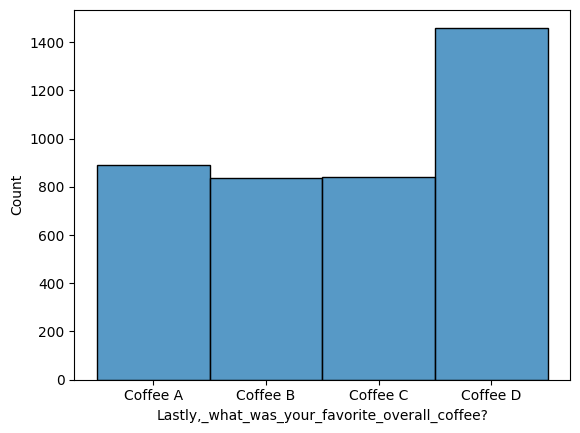

In [11]:
sns.histplot(x='Lastly,_what_was_your_favorite_overall_coffee?', data=df)
plt.show()

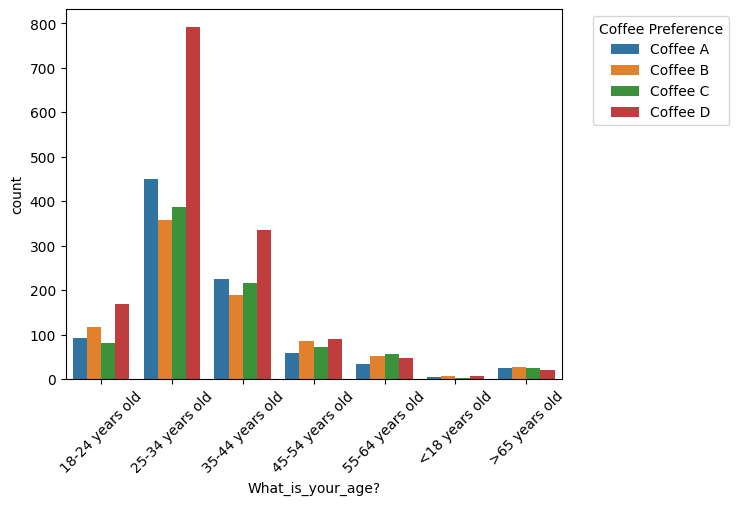

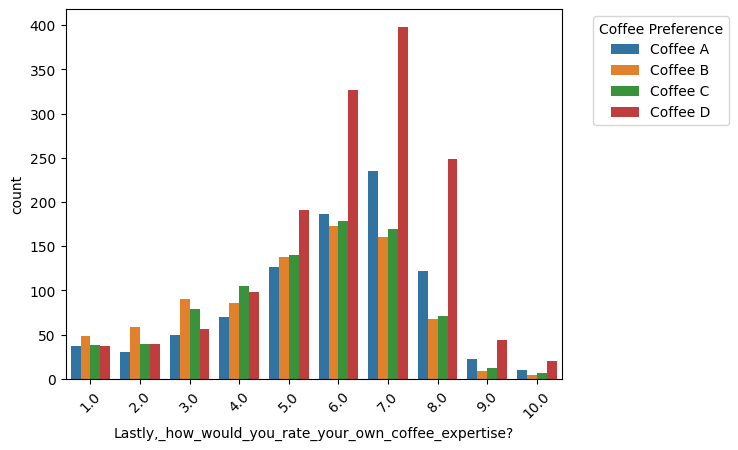

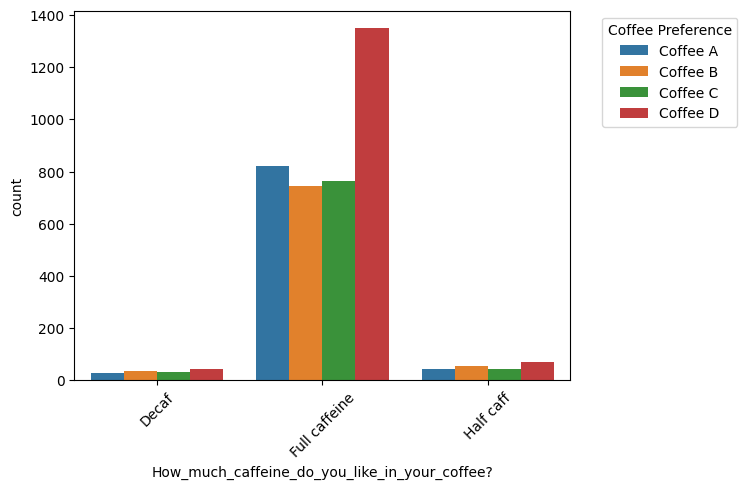

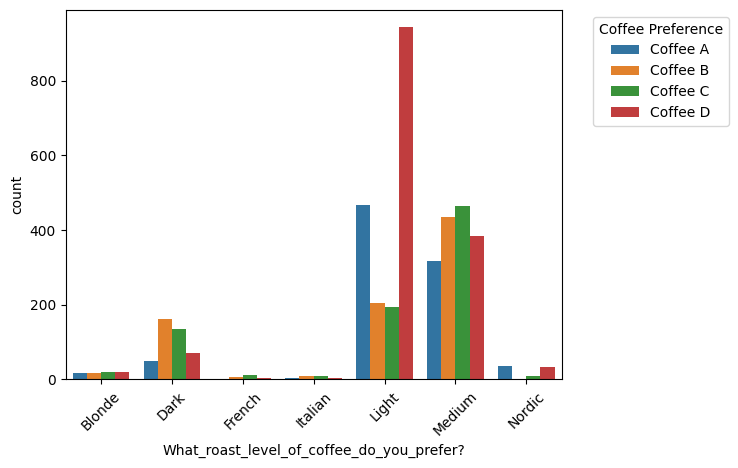

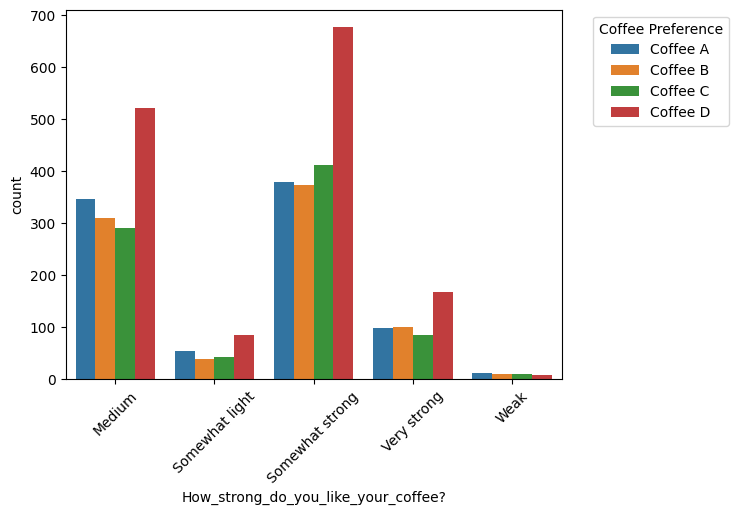

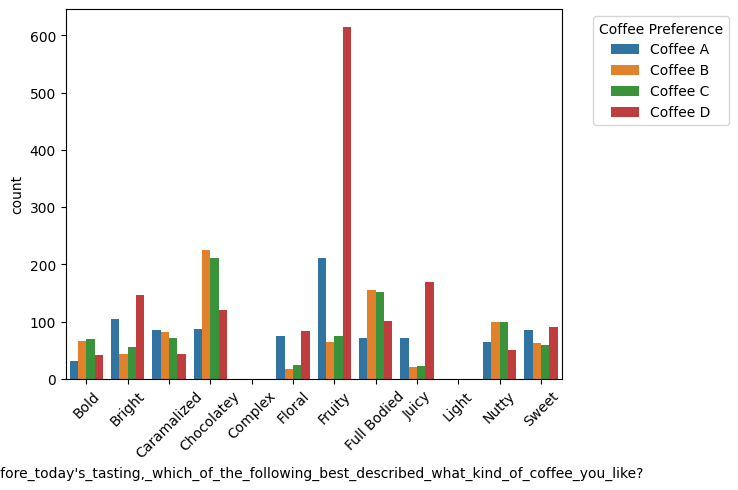

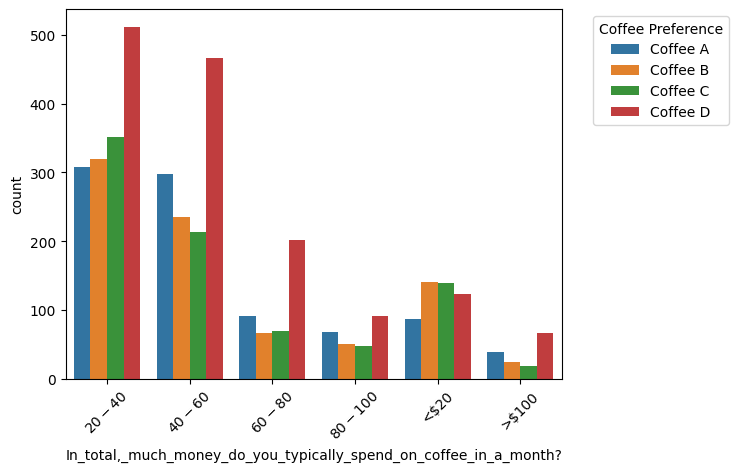

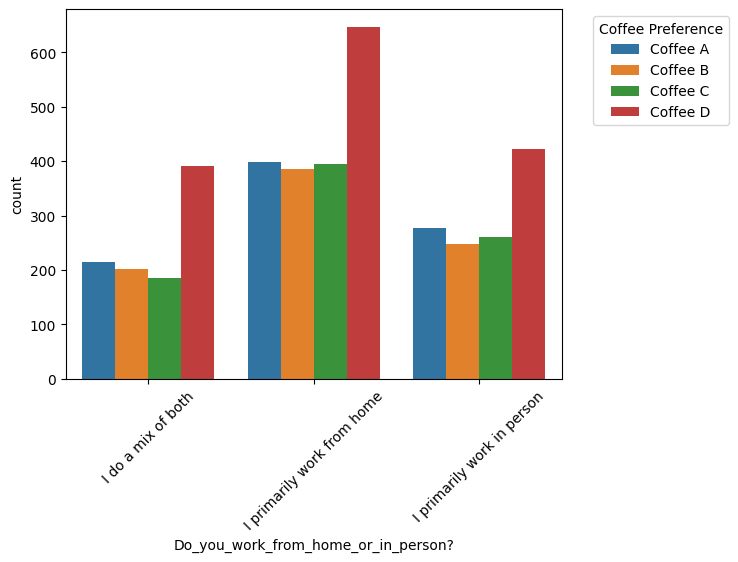

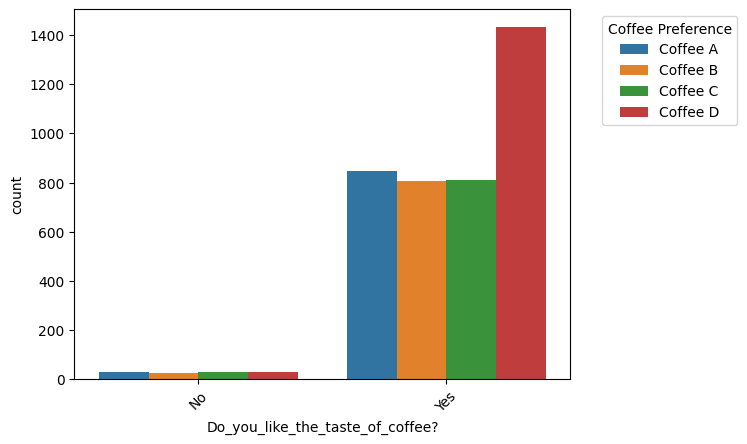

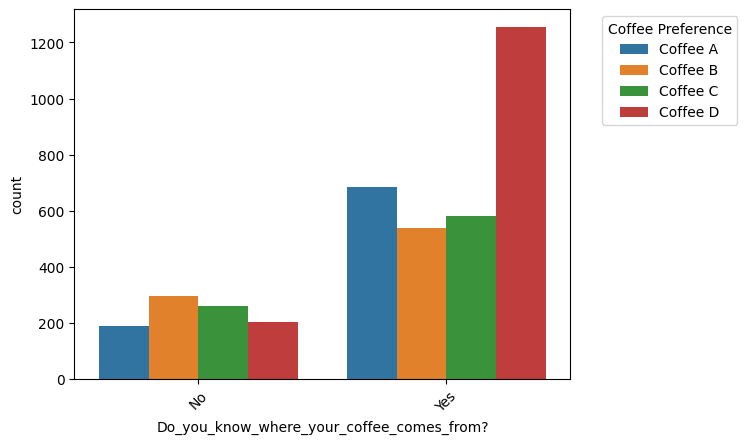

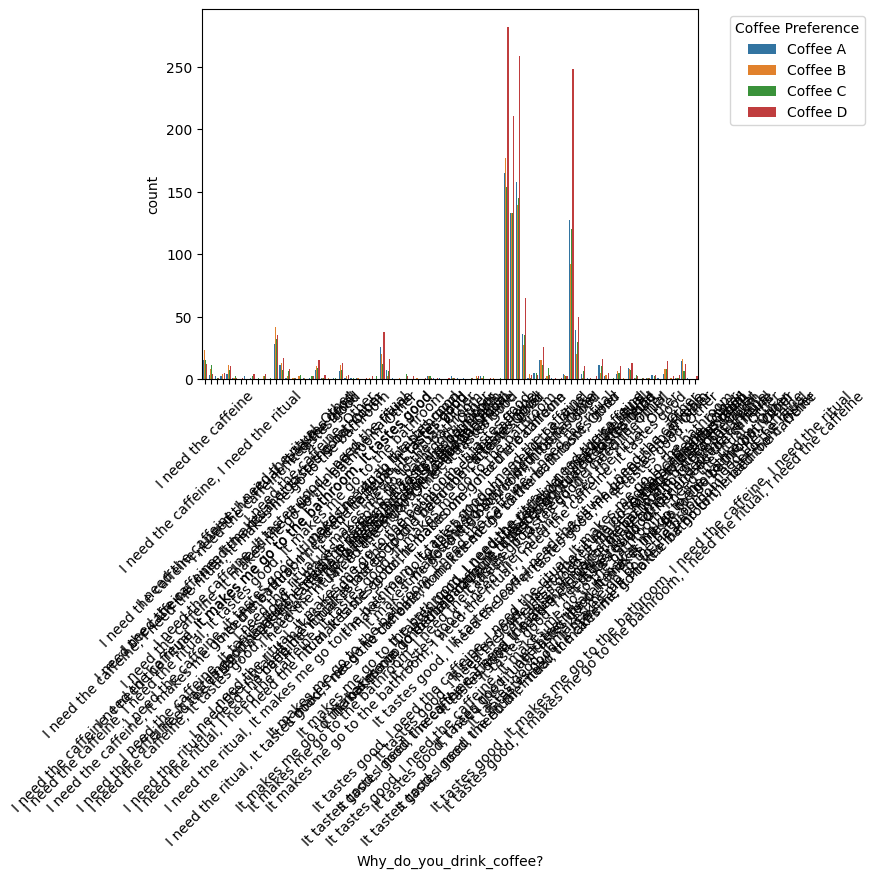

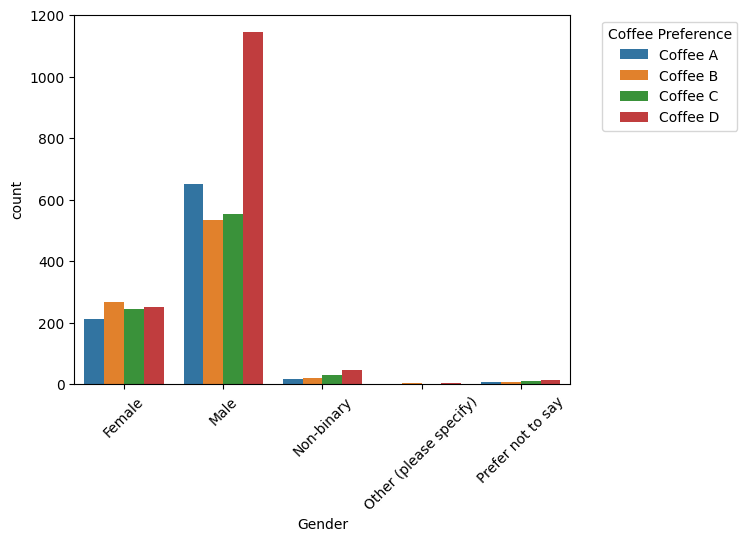

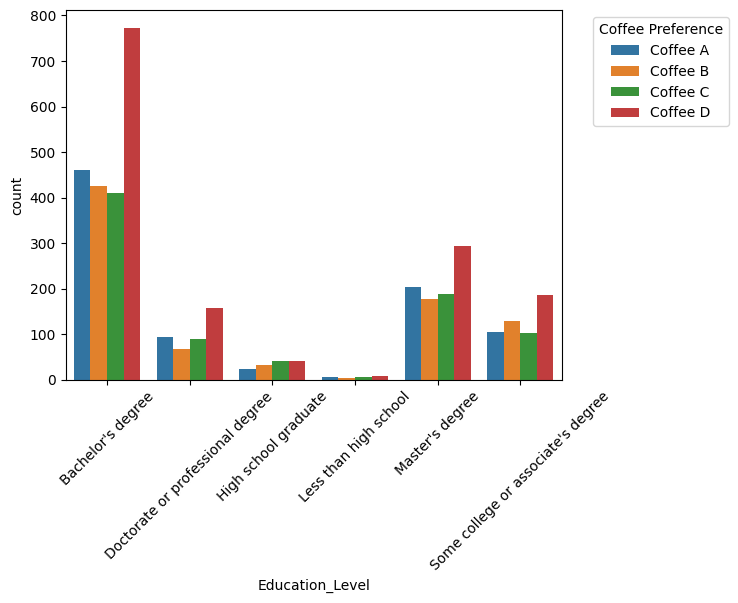

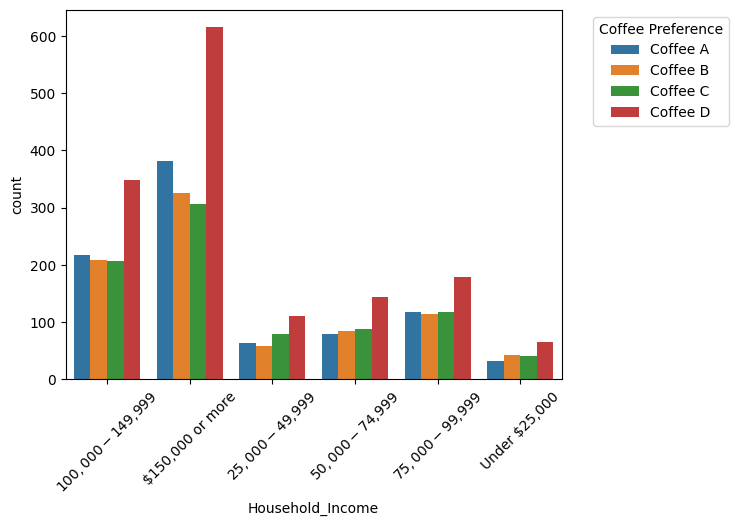

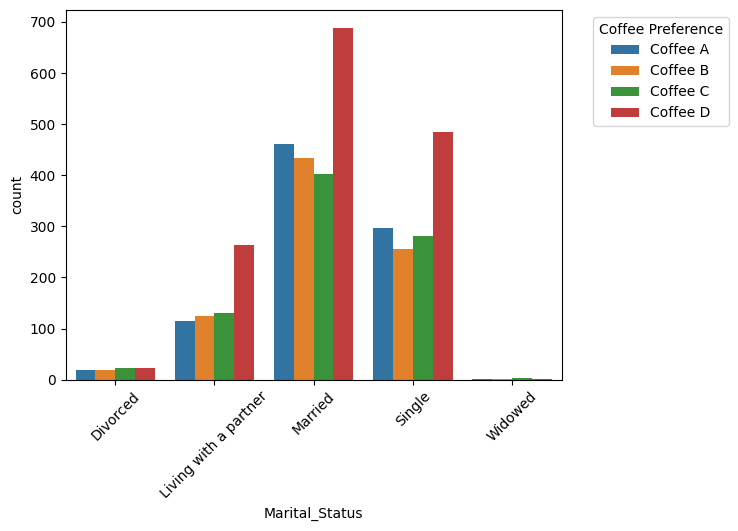

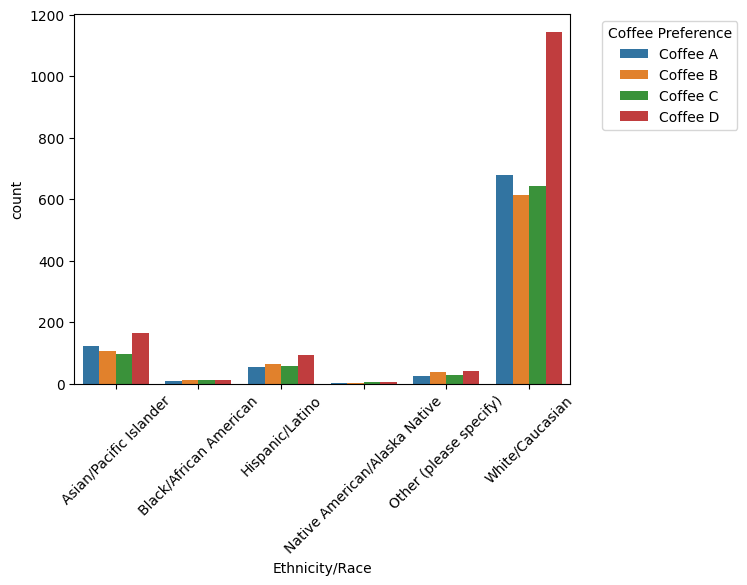

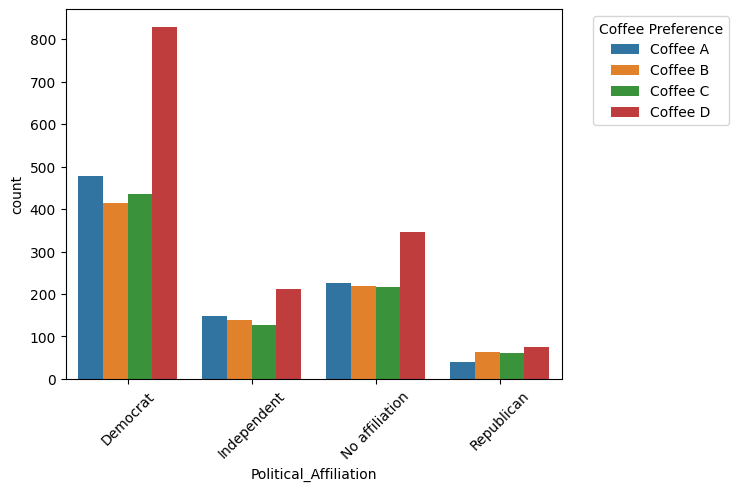

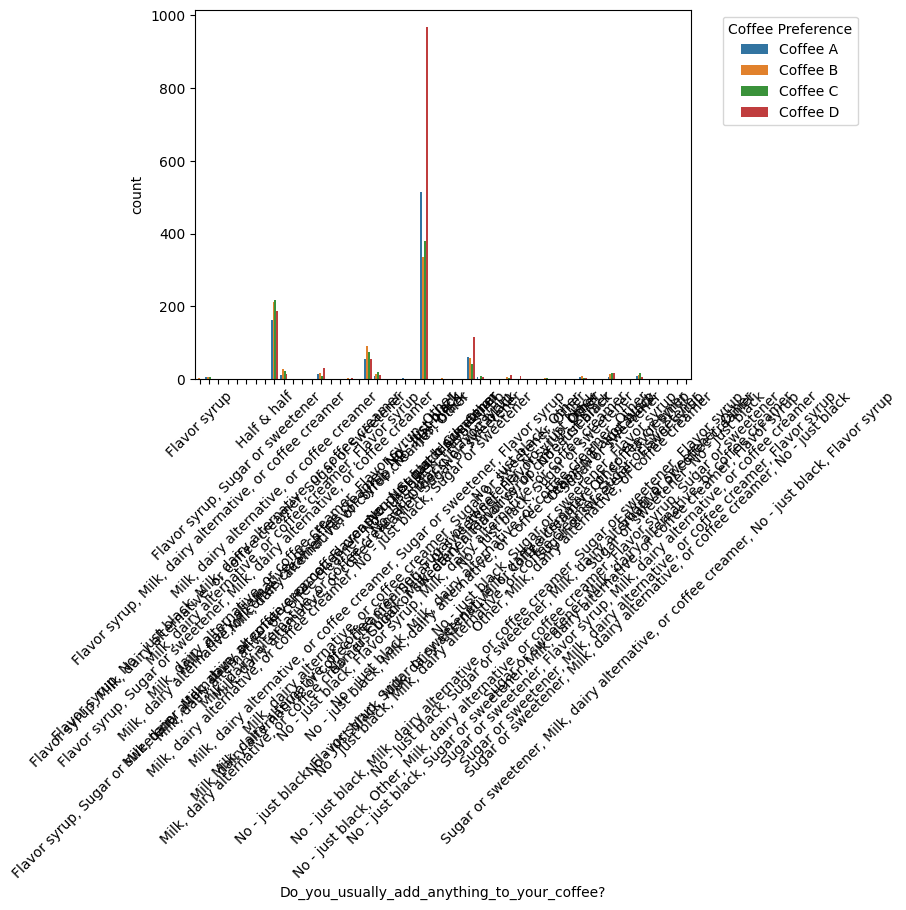

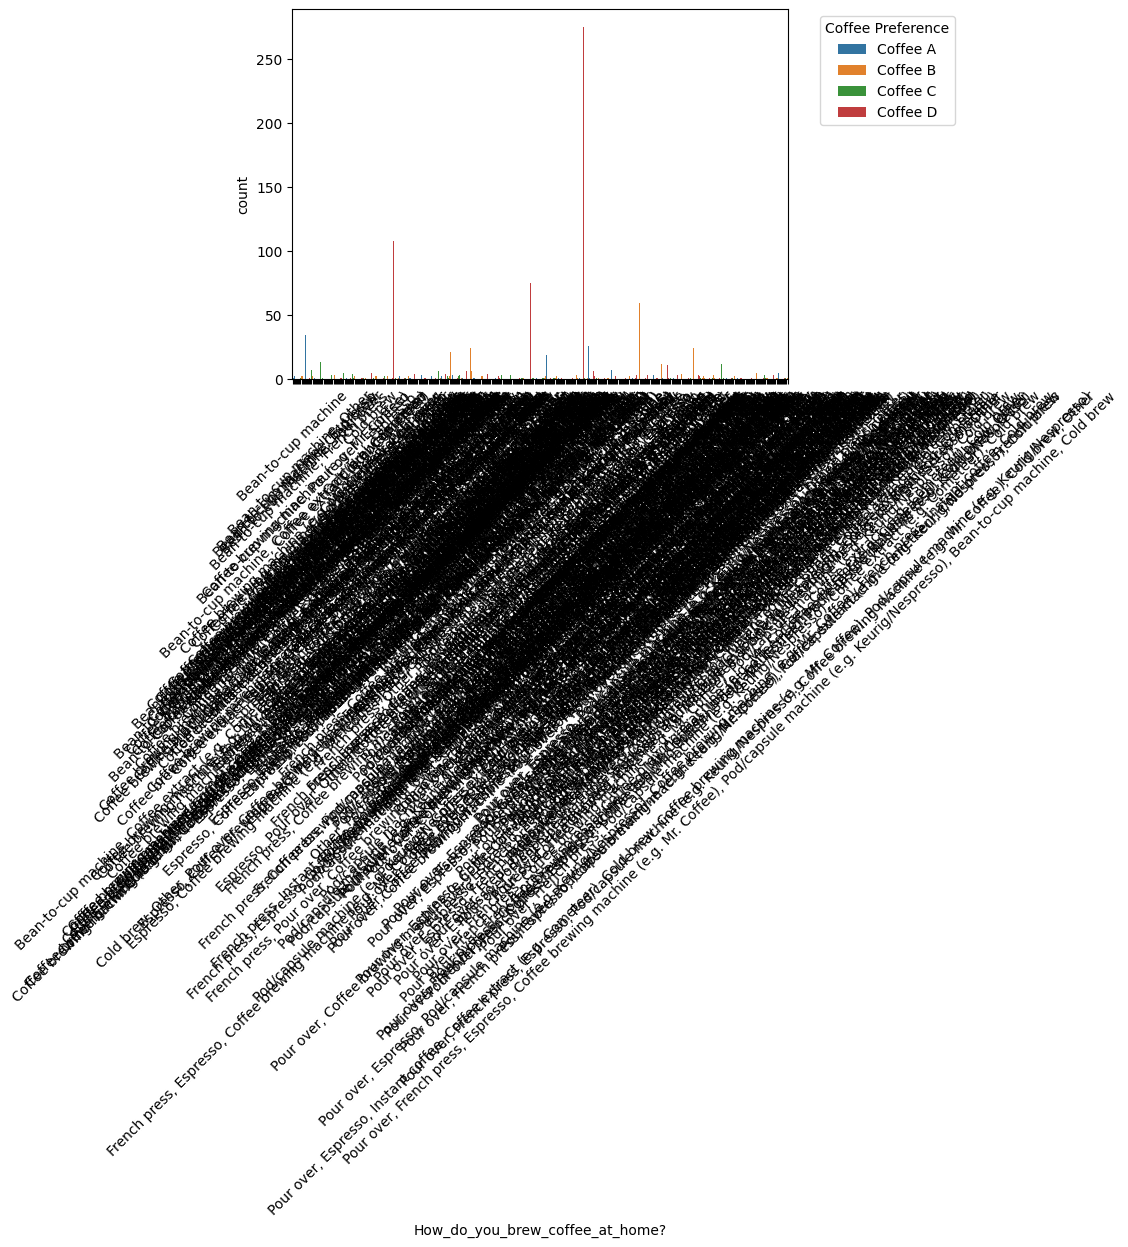

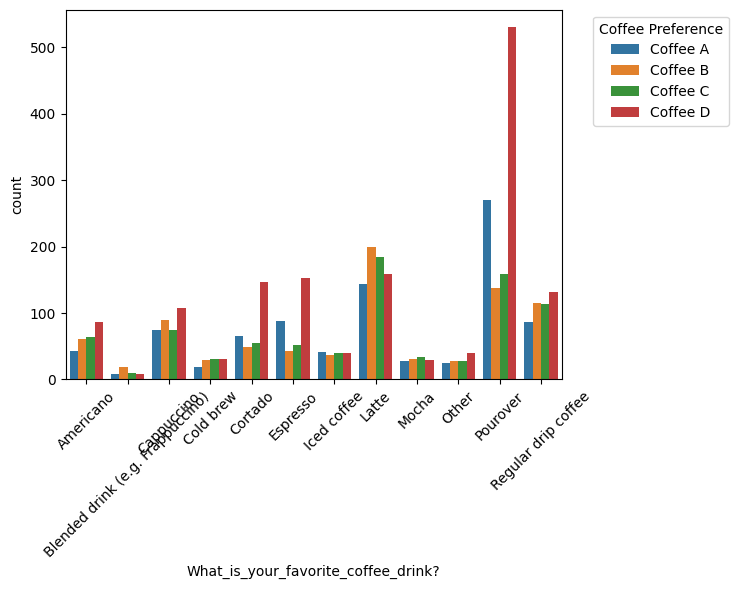

In [12]:
connections = [
    "What_is_your_age?",
    "Lastly,_how_would_you_rate_your_own_coffee_expertise?",
    "How_much_caffeine_do_you_like_in_your_coffee?",
    "What_roast_level_of_coffee_do_you_prefer?",
    "How_strong_do_you_like_your_coffee?",
    "Before_today's_tasting,_which_of_the_following_best_described_what_kind_of_coffee_you_like?",
    "In_total,_much_money_do_you_typically_spend_on_coffee_in_a_month?",
    "Do_you_work_from_home_or_in_person?",
    "Do_you_like_the_taste_of_coffee?",
    "Do_you_know_where_your_coffee_comes_from?",
    "Why_do_you_drink_coffee?",
    "Gender",
    "Education_Level",
    "Household_Income",
    "Marital_Status",
    "Ethnicity/Race",
    "Political_Affiliation",
    "Do_you_usually_add_anything_to_your_coffee?",
    "How_do_you_brew_coffee_at_home?",
    "What_is_your_favorite_coffee_drink?",
]

for col in connections:
    sns.countplot(x=col, hue='Lastly,_what_was_your_favorite_overall_coffee?', data=df)
    
    plt.legend(title='Coffee Preference', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)

    plt.show()

## This function makes three classifier models, and returns the best performing one (on a cross validated sample set)

In [13]:
def make_models(columns, data, show_importance=False, speed_up=False):
    df = data.copy()
    for feature in df:
        if feature not in columns and feature != 'Lastly,_what_was_your_favorite_overall_coffee?':
            df.drop(feature, axis=1, inplace=True)
    
    df = pd.get_dummies(df, columns=columns, drop_first=True)
    X = df.drop('Lastly,_what_was_your_favorite_overall_coffee?', axis=1).values
    y = df['Lastly,_what_was_your_favorite_overall_coffee?'].values
    
    scaler = StandardScaler().fit(X)
    
    X_scaled = scaler.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.3, random_state=11)
    
    rf = RandomForestClassifier(max_depth=5)
    rf.fit(X_train, y_train)
    
    if show_importance:
        feature_importances = rf.feature_importances_
        importance_df = pd.DataFrame({'Feature': df.drop('Lastly,_what_was_your_favorite_overall_coffee?', axis=1).columns, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        print(importance_df.head(100))
    if speed_up:
        models = [rf]
    else:
        lr = LogisticRegression()
        lr.fit(X_train, y_train)

        gb = GradientBoostingClassifier()
        gb.fit(X_train, y_train)

        models = [rf, lr, gb]
    max = 0
    best_model = None
    scores = {}
    for model in models:
        score = cross_val_score(model, X_test, y_test, cv=10).mean()
        scores[model] = score
        if score > max:
            max = score
            best_model = model
    
    return (scores, {best_model: max})

## Label Encode the target variable for modeling

In [14]:
label_encoder = LabelEncoder()
df['Lastly,_what_was_your_favorite_overall_coffee?'] = label_encoder.fit_transform(df['Lastly,_what_was_your_favorite_overall_coffee?'])

## Check What are the most important features

In [15]:
warnings.filterwarnings("ignore")
make_models(connections, df, show_importance=True)

                                               Feature  Importance
32   Before_today's_tasting,_which_of_the_following...    0.113319
21    What_roast_level_of_coffee_do_you_prefer?_Medium    0.085624
20     What_roast_level_of_coffee_do_you_prefer?_Light    0.066064
179  Do_you_usually_add_anything_to_your_coffee?_No...    0.039712
17      What_roast_level_of_coffee_do_you_prefer?_Dark    0.038543
29   Before_today's_tasting,_which_of_the_following...    0.031489
46       Do_you_know_where_your_coffee_comes_from?_Yes    0.030934
34   Before_today's_tasting,_which_of_the_following...    0.027715
665       What_is_your_favorite_coffee_drink?_Pourover    0.024024
33   Before_today's_tasting,_which_of_the_following...    0.021217
163  Do_you_usually_add_anything_to_your_coffee?_Mi...    0.019050
662          What_is_your_favorite_coffee_drink?_Latte    0.017905
28   Before_today's_tasting,_which_of_the_following...    0.015714
219  How_do_you_brew_coffee_at_home?_Coffee brewing...    0.01

({RandomForestClassifier(max_depth=5): 0.37924400487738785,
  LogisticRegression(): 0.35949735808156075,
  GradientBoostingClassifier(): 0.42706272862755723},
 {GradientBoostingClassifier(): 0.42706272862755723})

## Make models with only the important features

In [16]:
importants = [
    "Before_today's_tasting,_which_of_the_following_best_described_what_kind_of_coffee_you_like?",
    "What_roast_level_of_coffee_do_you_prefer?",
    "Do_you_know_where_your_coffee_comes_from?",
    "Gender",
    "Lastly,_how_would_you_rate_your_own_coffee_expertise?",
]

In [17]:
make_models(importants, df)

({RandomForestClassifier(max_depth=5): 0.4245562931852052,
  LogisticRegression(): 0.4295420674705325,
  GradientBoostingClassifier(): 0.40807478661428},
 {LogisticRegression(): 0.4295420674705325})

## Check the scoring of having one-feature models

In [18]:
for col in connections:
    print(f"{col}: \n{make_models([col], df)[1]}\n")

What_is_your_age?: 
{GradientBoostingClassifier(): 0.35784446551957727}

Lastly,_how_would_you_rate_your_own_coffee_expertise?: 
{RandomForestClassifier(max_depth=5): 0.3619496003251592}

How_much_caffeine_do_you_like_in_your_coffee?: 
{RandomForestClassifier(max_depth=5): 0.3528451429345617}

What_roast_level_of_coffee_do_you_prefer?: 
{LogisticRegression(): 0.385828478525945}

How_strong_do_you_like_your_coffee?: 
{RandomForestClassifier(max_depth=5): 0.36027638531364314}

Before_today's_tasting,_which_of_the_following_best_described_what_kind_of_coffee_you_like?: 
{LogisticRegression(): 0.4460709930903672}

In_total,_much_money_do_you_typically_spend_on_coffee_in_a_month?: 
{LogisticRegression(): 0.3544777130470126}

Do_you_work_from_home_or_in_person?: 
{RandomForestClassifier(max_depth=5): 0.3569773743395204}

Do_you_like_the_taste_of_coffee?: 
{RandomForestClassifier(max_depth=5): 0.3635686221379217}

Do_you_know_where_your_coffee_comes_from?: 
{LogisticRegression(): 0.3726527570

## If we include all columns, what are the most important features

In [19]:
all_columns = df.drop('Lastly,_what_was_your_favorite_overall_coffee?', axis=1).columns
make_models(all_columns, df, show_importance=True, speed_up=True)

                                                 Feature  Importance
19468  Between_Coffee_A,_Coffee_B,_and_Coffee_C_which...    0.041609
19467  Between_Coffee_A,_Coffee_B,_and_Coffee_C_which...    0.040775
12669                 Coffee_B_-_Personal_Preference_5.0    0.037023
17091                 Coffee_D_-_Personal_Preference_5.0    0.035359
19469  Between_Coffee_A_and_Coffee_D,_which_did_you_p...    0.024049
17088                 Coffee_D_-_Personal_Preference_2.0    0.020875
10282  Before_today's_tasting,_which_of_the_following...    0.017609
9585    How_do_you_brew_coffee_at_home?_(Pour_over)_True    0.016823
17089                 Coffee_D_-_Personal_Preference_3.0    0.016664
10296   What_roast_level_of_coffee_do_you_prefer?_Medium    0.016075
12666                 Coffee_B_-_Personal_Preference_2.0    0.015470
14893                 Coffee_C_-_Personal_Preference_3.0    0.015031
9972   Do_you_usually_add_anything_to_your_coffee?_No...    0.014919
10283  Before_today's_tasting,_whi

({RandomForestClassifier(max_depth=5): 0.38089689743937133},
 {RandomForestClassifier(max_depth=5): 0.38089689743937133})

## Experiments with different features 

### (If we include a result of the test, then we can predict a result of the test - i.e. coffee_D_Personal_Preference - this is no surprise, so I remove it for the rest of my tests)

In [ ]:
importants = [
    "Before_today's_tasting,_which_of_the_following_best_described_what_kind_of_coffee_you_like?",
    "What_roast_level_of_coffee_do_you_prefer?",
    "Do_you_know_where_your_coffee_comes_from?",
    "What_is_your_favorite_coffee_drink?",
    "Lastly,_how_would_you_rate_your_own_coffee_expertise?",
    "Coffee_D_-_Personal_Preference",
    "Do_you_usually_add_anything_to_your_coffee?",
    "How_do_you_brew_coffee_at_home?",
]
make_models(importants, df)

In [ ]:
importants = [
    "Before_today's_tasting,_which_of_the_following_best_described_what_kind_of_coffee_you_like?",
    "What_roast_level_of_coffee_do_you_prefer?",
    "Do_you_know_where_your_coffee_comes_from?",
    "What_is_your_favorite_coffee_drink?",
    "Lastly,_how_would_you_rate_your_own_coffee_expertise?",
    "Do_you_usually_add_anything_to_your_coffee?",
    "How_do_you_brew_coffee_at_home?",
]
make_models(importants, df)

In [ ]:
importants = [
    "Before_today's_tasting,_which_of_the_following_best_described_what_kind_of_coffee_you_like?",
    "What_roast_level_of_coffee_do_you_prefer?",
    "What_is_your_favorite_coffee_drink?",
    "Do_you_usually_add_anything_to_your_coffee?",
    "How_do_you_brew_coffee_at_home?",
]
make_models(importants, df)

In [ ]:
importants = [
    "Before_today's_tasting,_which_of_the_following_best_described_what_kind_of_coffee_you_like?",
    "What_roast_level_of_coffee_do_you_prefer?",
    "Do_you_usually_add_anything_to_your_coffee?",
    "How_do_you_brew_coffee_at_home?",
]
make_models(importants, df)

In [ ]:
importants = [
    "What_roast_level_of_coffee_do_you_prefer?",
    "Do_you_usually_add_anything_to_your_coffee?",
    "How_do_you_brew_coffee_at_home?",
]
make_models(importants, df)

In [ ]:
importants = [
    "What_roast_level_of_coffee_do_you_prefer?",
    "Do_you_usually_add_anything_to_your_coffee?",
    "How_do_you_brew_coffee_at_home?",
    "What_is_your_favorite_coffee_drink?",
]
make_models(importants, df)

## Overall the best performing model had the following columns

importants = [
    "Before_today's_tasting,_which_of_the_following_best_described_what_kind_of_coffee_you_like?",
    "What_roast_level_of_coffee_do_you_prefer?",
    "Do_you_usually_add_anything_to_your_coffee?",
    "How_do_you_brew_coffee_at_home?",
]

## However, even this one was really bad at predicting (.45 accuracy), but that is better than random chance (.25)

## Including just one column accounts for most of this accuracy
Before_today's_tasting,_which_of_the_following_best_described_what_kind_of_coffee_you_like?